<a href="https://colab.research.google.com/github/MokshAggarwal/Image-Deblurring-Using-GANS/blob/main/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pickle
import numpy as np
import cv2
from keras import models, layers
import warnings
warnings.filterwarnings("ignore")
import random
import tensorflow as tf
# tf.keras.datasets.fashion_mnist.load_data()
from keras import datasets
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# (X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
# X_train, X_test = X_train/255, X_test/255

In [ ]:
# X -> Blurred, Y -> Sharp

X = np.array(pickle.load(open('/content/drive/MyDrive/CV_Dataset/X_train_256.pkl', "rb")))
# X = np.uint8(X)
Y = np.array(pickle.load(open('/content/drive/MyDrive/CV_Dataset/Y_train_256.pkl', "rb")))

In [ ]:
X = X * 127.5 + 127.5
X = np.uint8(X)

Y = Y * 127.5 + 127.5
Y = np.uint8(Y)

In [ ]:
ind = 0
temp = []
blur_train = []

for i in range(X.shape[0]):
    # print(X_train[i].shape)
    img = cv2.cvtColor(X[i], cv2.COLOR_BGR2GRAY)
    temp.append(img)
    # print(i.shape)
    # break

for i in range(len(temp)):
    # print(i.shape)
    img = cv2.resize(temp[i], (28, 28))
    # img = img.reshape((28, 28, 1))
    blur_train.append(img)
    # print(i.shape)
    # break

print(blur_train[0].shape)
X = np.array(blur_train)

(28, 28)


In [ ]:
ind = 0
temp = []
blur_test = []

for i in range(Y.shape[0]):
    # print(X_train[i].shape)
    img = cv2.cvtColor(Y[i], cv2.COLOR_BGR2GRAY)
    temp.append(img)
    # print(i.shape)
    # break

for i in range(len(temp)):
    # print(i.shape)
    img = cv2.resize(temp[i], (28, 28))
    # img = img.reshape((28, 28, 1))
    blur_test.append(img)
    # print(i.shape)
    # break

Y = np.array(blur_test)

In [ ]:
X_train, X_test, noise_train, noise_test = train_test_split(Y, X, test_size = 0.1, random_state = 42)
# X_train, X_test = train_test_split(Y, test_size = 0.1, random_state = 42)

In [ ]:
# def add_noise(X):
#     result = []
#     for img in X:
#         noisy = cv2.GaussianBlur(img, (3, 3), 0)
#         noisy = np.clip(noisy, 0, 1)
#         result.append(noisy)
#     return np.array(result)

# noise_train = add_noise(X_train)
# noise_test = add_noise(X_test)

In [ ]:
X_train, X_test = X_train / 255, X_test / 255
noise_train, noise_test = noise_train / 255, noise_test / 255

In [ ]:
print(X_train.shape)
print(X_test.shape)

(1035, 28, 28)
(116, 28, 28)


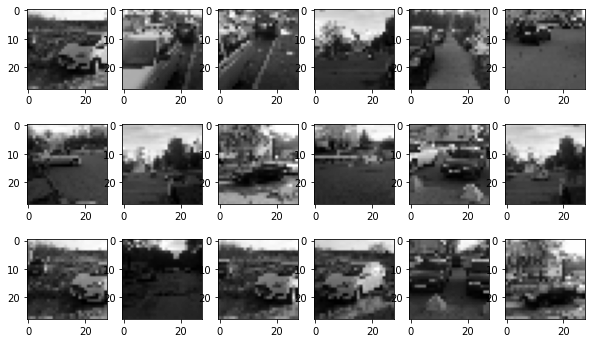

In [ ]:
class_names = list(range(10))
plt.figure(figsize=(10,6))
for i in range(18):
    plt.subplot(3,6,i+1)
    plt.grid(False)
    plt.imshow(X_train[i], cmap = 'gray')
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    # plt.xlabel(class_names[y_train[i]])
plt.show()

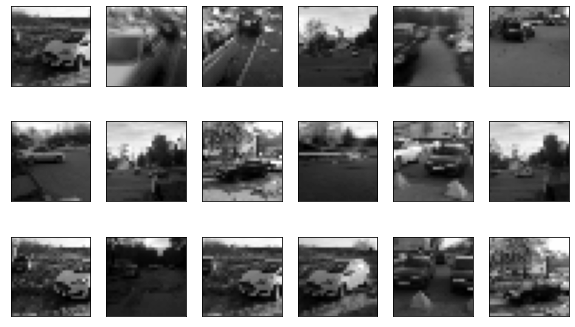

In [ ]:
class_names = list(range(10))
plt.figure(figsize=(10,6))
for i in range(18):
    plt.subplot(3,6,i+1)
    plt.grid(False)
    plt.imshow(noise_train[i], cmap = 'gray')
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    # plt.xlabel(class_names[y_train[i]])
plt.show()

In [ ]:
model = models.Sequential()

#encode

model.add(layers.Conv2D(64, (2, 2), strides = 1, padding = 'same', input_shape = (28, 28, 1)))
model.add(layers.Conv2D(32, (2, 2), strides = 1, padding = 'same'))
model.add(layers.Conv2D(16, (2, 2), strides = 1, padding = 'same'))

#latent
model.add(layers.Conv2D(8, (2, 2), strides = 1, padding = 'same'))

#decode
model.add(layers.Conv2DTranspose(16, (2, 2), strides = 1, padding = 'same'))
model.add(layers.Conv2DTranspose(32, (2, 2), strides = 1, padding = 'same'))
model.add(layers.Conv2DTranspose(64, (2, 2), strides = 1, padding = 'same'))
model.add(layers.Conv2DTranspose(1, (1, 1), strides = 1, activation = 'sigmoid', padding = 'same'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 64)        320       
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 32)        8224      
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 16)        2064      
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 8)         520       
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 28, 28, 16)       528       
 ranspose)                                                       
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 28, 28, 32)       2080      
 ranspose)                                            

In [ ]:
from keras import optimizers
opt = tf.keras.optimizers.SGD(lr=1e-4)

model.compile(loss = 'mse', optimizer = 'adam')

In [ ]:
import tensorflow as tf
with tf.device('/device:GPU:0'):
    model.fit(noise_train.reshape(-1, 28, 28, 1), X_train.reshape(-1, 28, 28, 1), epochs = 100, batch_size = 5, validation_data = (noise_test.reshape(-1, 28, 28, 1), X_test.reshape(-1, 28, 28, 1)))

Epoch 1/100
207/207 [==============================] - 3s 9ms/step - loss: 0.0096 - val_loss: 0.0033
Epoch 2/100
207/207 [==============================] - 2s 8ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 3/100
207/207 [==============================] - 2s 8ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 4/100
207/207 [==============================] - 2s 8ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 5/100
207/207 [==============================] - 2s 8ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 6/100
207/207 [==============================] - 2s 8ms/step - loss: 0.0023 - val_loss: 0.0025
Epoch 7/100
207/207 [==============================] - 2s 8ms/step - loss: 0.0023 - val_loss: 0.0025
Epoch 8/100
207/207 [==============================] - 2s 8ms/step - loss: 0.0023 - val_loss: 0.0025
Epoch 9/100
207/207 [==============================] - 2s 8ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 10/100
207/207 [==============================] - 2s 8ms/step - loss: 0.0023 - val_lo

In [ ]:
#utility function to pick samples to be tested
def get_samples(arr, n):
    temp = random.sample(range(len(arr)), n)
    result = arr[temp]
    return result, temp


In [ ]:
num = 15
org, temp = get_samples(X_test, num)
blur = noise_test[temp]
preds = model.predict(blur.reshape(-1, 28, 28, 1))
preds = preds.reshape(-1, 28, 28)

Original Images


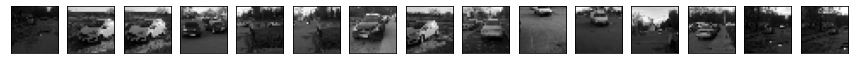

Blurred Images


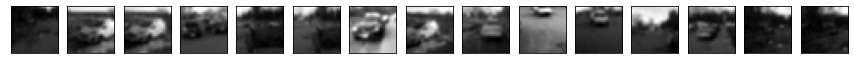

Predicted Images


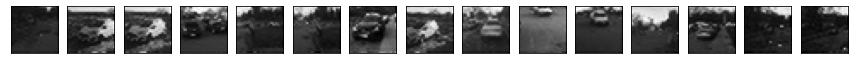

In [ ]:
plt.figure(figsize = (15, 15))
print('Original Images')
for i in range(num):
    plt.subplot(1, num, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(org[i], cmap = 'gray')
plt.show()

plt.figure(figsize = (15, 15))
print('Blurred Images')
for i in range(num):
    plt.subplot(1, num, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(blur[i], cmap = 'gray')
plt.show()

plt.figure(figsize = (15, 15))
print('Predicted Images')
for i in range(num):
    plt.subplot(1, num, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(preds[i], cmap = 'gray')
plt.show()

Original Images


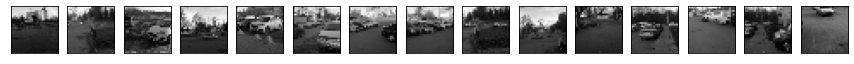

Blurred Images


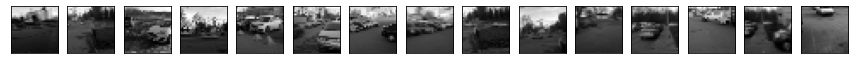

Predicted Images


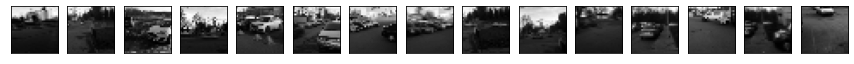

In [ ]:
plt.figure(figsize = (15, 15))
print('Original Images')
for i in range(num):
    plt.subplot(1, num, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(org[i], cmap = 'gray')
plt.show()

plt.figure(figsize = (15, 15))
print('Blurred Images')
for i in range(num):
    plt.subplot(1, num, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(blur[i], cmap = 'gray')
plt.show()

plt.figure(figsize = (15, 15))
print('Predicted Images')
for i in range(num):
    plt.subplot(1, num, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(preds[i], cmap = 'gray')
plt.show()